In [92]:
import datetime
import os

import requests
import pandas as pd
import matplotlib.pyplot as pl
import yaml
import numpy as np

In [9]:
with open(os.path.expanduser('~/.config/vigilant-crypto-snatch.yml')) as f:
    config = yaml.safe_load(f)
api_key = config['cryptocompare']['api_key']

In [16]:
timestamp = int(datetime.datetime.now().timestamp())
timestamp

1615923791

In [39]:
url = f'https://min-api.cryptocompare.com/data/histohour?api_key={api_key}&fsym=BTC&tsym=EUR&limit=2000&toTs={timestamp}'

In [40]:
r = requests.get(url)

In [41]:
r

<Response [200]>

In [42]:
data = r.json()['Data']
df = pd.DataFrame(data)

In [43]:
df

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
0,1608721200,19267.64,18732.09,19246.71,2397.88,45418504.41,18969.71,direct,
1,1608724800,19580.91,18856.75,18969.71,1646.43,31691231.32,19573.72,direct,
2,1608728400,19784.46,19270.01,19573.72,1881.90,36824089.09,19384.43,direct,
3,1608732000,19551.07,19333.74,19384.43,864.58,16799430.46,19470.07,direct,
4,1608735600,19581.43,19183.15,19470.07,943.17,18283972.60,19268.55,direct,
...,...,...,...,...,...,...,...,...,...
1996,1615906800,46943.53,46646.34,46730.86,539.97,25271674.77,46934.79,direct,
1997,1615910400,47120.64,46658.64,46934.79,479.44,22485742.46,46825.04,direct,
1998,1615914000,46946.24,46187.20,46825.04,571.56,26571941.25,46432.65,direct,
1999,1615917600,46733.26,46320.71,46432.65,340.61,15845703.22,46505.40,direct,


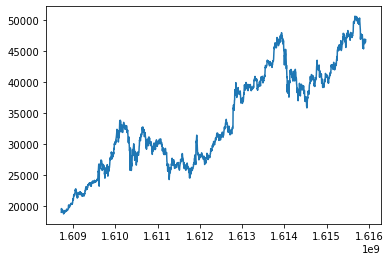

In [44]:
pl.clf()
pl.plot(df['time'], df['close'])
pl.show()

In [46]:
df['close'].shift()

0            NaN
1       18969.71
2       19573.72
3       19384.43
4       19470.07
          ...   
1996    46730.86
1997    46934.79
1998    46825.04
1999    46432.65
2000    46505.40
Name: close, Length: 2001, dtype: float64

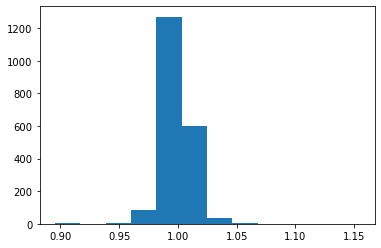

In [50]:
pl.clf()
pl.hist(df['close'].shift() / df['close'], bins='sturges')
pl.show()

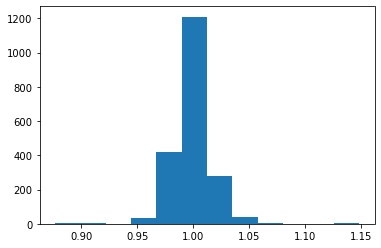

In [51]:
pl.clf()
pl.hist(df['close'].shift(2) / df['close'], bins='sturges')
pl.show()

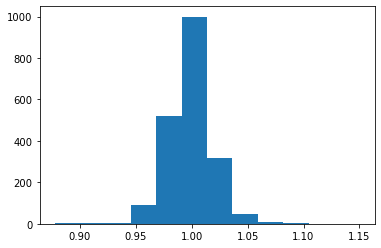

In [52]:
pl.clf()
pl.hist(df['close'].shift(3) / df['close'], bins='sturges')
pl.show()

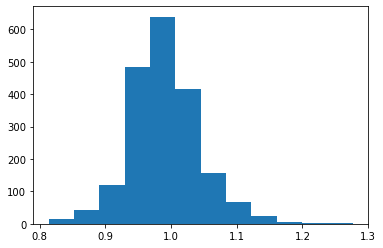

In [53]:
pl.clf()
pl.hist(df['close'].shift(24) / df['close'], bins='sturges')
pl.show()

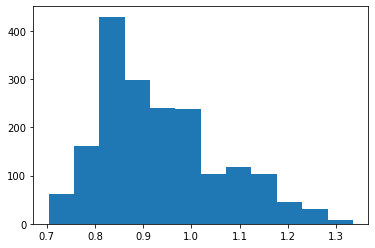

In [54]:
pl.clf()
pl.hist(df['close'].shift(7 * 24) / df['close'], bins='sturges')
pl.show()

In [106]:
def compute_gains(df: pd.DataFrame, hours: int, drop: float):
    close_shift = df['close'].shift(hours)
    ratio = df['close'] / close_shift
    
    btc = 0.0
    eur = 0.0

    last = -hours
    
    for i in range(len(df)):
        if ratio[i] < (1-drop) and last + hours <= i:
            last = i
            btc += 1.0 / df['close'][i]
            eur += 1.0
    return btc, eur, btc / eur if eur > 0 else 0.0

In [105]:
def compute_dca(df: pd.DataFrame, hours: int):    
    btc = 0.0
    eur = 0.0
    
    last = -hours
    
    for i in range(len(df)):
        if last + hours <= i:
            last = i
            btc += 1.0 / df['close'][i]
            eur += 1.0
    return btc, eur, btc / eur if eur > 0 else 0.0

In [87]:
compute_gains(df, 1, 0.05)

(0.00018338533396577644, 5.0, 3.667706679315529e-05)

In [88]:
compute_gains(df, 2, 0.05)

(0.00021539932193016136, 6.0, 3.5899886988360225e-05)

In [89]:
compute_dca(df, 1)

(0.06272436842799423, 2001.0, 3.1346510958517855e-05)

In [90]:
compute_dca(df, 2)

(0.03137736877627134, 1001.0, 3.134602275351782e-05)

In [115]:
hours = np.arange(1, 25)
drops = np.linspace(0.01, 0.25, 15)
factor = np.zeros(hours.shape + drops.shape)

In [116]:
for i, hour in enumerate(hours):
    for j, drop in enumerate(drops):
        factor[i, j] = compute_gains(df, hour, drop)[2]

<ipython-input-117-0dc9374620ff>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pl.pcolormesh(hours, drops * 100, factor.T, cmap='turbo')


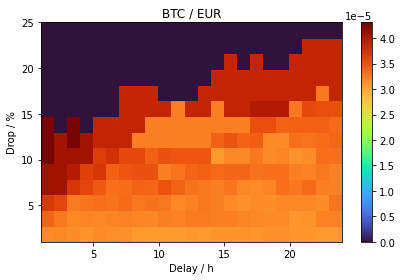

In [117]:
pl.clf()
pl.pcolormesh(hours, drops * 100, factor.T, cmap='turbo')
pl.colorbar()
pl.title('BTC / EUR')
pl.xlabel('Delay / h')
pl.ylabel('Drop / %')
pl.tight_layout()
pl.savefig('gains.pdf')
pl.show()